In [1]:
import cv2
import numpy as np
import pandas as pd
import os  
from random import shuffle
from IPython.display import display, Markdown
from tqdm import tqdm
import PIL
from PIL import Image
import seaborn as sn
from itertools import cycle
import datetime

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization

from matplotlib.pyplot import imshow
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

sn.set()

df = pd.read_csv('data/individual_details.csv')


img_path = 'mugshots/mugs'
img_w = 120
img_h = 150
learning_rate = .001

Using TensorFlow backend.


In [2]:
df['booking_date'] = pd.to_datetime(df['booking_date'])
df['bday'] = pd.to_datetime(df['bday'])

df['age'] = round((df["booking_date"] - df["bday"]).dt.days / 365)

In [3]:
df.head()

,booking_number,booking_date,sex,height,weight,eye_color,hair_color,bday,crime_type_expanded,age
0,T626990,2020-03-18,MALE,6'02,155,BROWN,BROWN,1996-12-16,"['THREAT-INTIMIDATE-GANG', 'AGGRAVATED ROBBERY...",23.0
1,T626991,2020-03-18,MALE,5'11,250,BROWN,BLACK,1976-04-12,"['AGG ASLT-DEADLY WPN/DANG INST', 'DISORDERLY ...",44.0
2,T626994,2020-03-18,MALE,5'06,190,BROWN,BLACK,1993-10-27,"['PROBATION VIOLATION', 'AGG ASLT-DEADLY WPN/D...",26.0
3,T626995,2020-03-18,MALE,5'09,140,BROWN,BROWN,1998-01-07,"['RESIST ARREST-RISK PHYS INJ', 'CRIMINAL DAMA...",22.0
4,T626997,2020-03-18,FEMALE,5'05,115,BROWN,BROWN,1973-07-16,['CHILD/VUL ADULT ABUSE-INTENT'],47.0


In [4]:
age_bins = list(np.arange(18,60,12))
# age_bins = [18, 25, 40, 50]

age_labels = []

for n, i in zip(age_bins, range(len(age_bins))):  
    if n == age_bins[0]:
        pass
    else:
        age_labels.append(f'{age_bins[i-1]}-{n}')

final_bin = f'>{age_bins[-1]}'

df['age_bins'] = pd.cut(x=df['age'], bins=age_bins, labels=age_labels).astype(str)
df['age_bins'] = df.age_bins.replace('nan', final_bin)

age_labels.append(final_bin)

df = pd.get_dummies(df, columns=['age_bins'], drop_first=False)

In [5]:
def label_img(img):
    booking_id = img.split('.')[0]
    
    index_pos = int(df[df['booking_number'] == booking_id].index.values)
    
    return list(df.iloc[index_pos][-(len(age_labels)):])

    
def process_img():
    processed_data = []
    for img in tqdm(os.listdir(img_path)):
        label = label_img(img)
        path = os.path.join(img_path,img)
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (img_w,img_h))
        processed_data.append([np.array(img),np.array(label)])
    shuffle(processed_data)
#     np.save('data/train_data.npy', processed_data)
    return processed_data


# split data into train and test
def split_img(img, train=.8):
    length = len(img)
    cut_off = round(len(images)*train)
    
    return img[:cut_off], img[cut_off:]

In [6]:
images = process_img()

100%|██████████| 4701/4701 [00:22<00:00, 207.16it/s]


# Keras

In [7]:
train, test = split_img(images)

trainImages = np.array([i[0] for i in train]).reshape(-1, img_w, img_h, 3)
trainLabels = np.array([i[1] for i in train])

testImages = np.array([i[0] for i in test]).reshape(-1, img_w, img_h, 3)
testLabels = np.array([i[1] for i in test])

In [8]:
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Conv2D(32, kernel_size = (3, 3), activation='relu', input_shape=(img_w, img_h, 3)))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Conv2D(96, kernel_size=(3,3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Conv2D(96, kernel_size=(3,3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(len(age_bins), activation = 'softmax'))

In [9]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

In [10]:
model.fit(trainImages, trainLabels, batch_size = 50, epochs = 20, verbose = 1)

Train on 3761 samples
Epoch 1/20
3761/3761 [==============================] - 36s 10ms/sample - loss: 1.1573 - acc: 0.4727
Epoch 2/20
3761/3761 [==============================] - 36s 10ms/sample - loss: 1.0834 - acc: 0.5084
Epoch 3/20
3761/3761 [==============================] - 36s 10ms/sample - loss: 1.0608 - acc: 0.5150
Epoch 4/20
3761/3761 [==============================] - 36s 10ms/sample - loss: 1.0432 - acc: 0.5217
Epoch 5/20
3761/3761 [==============================] - 36s 10ms/sample - loss: 1.0126 - acc: 0.5390
Epoch 6/20
3761/3761 [==============================] - 36s 10ms/sample - loss: 1.0045 - acc: 0.5440
Epoch 7/20
3761/3761 [==============================] - 36s 10ms/sample - loss: 0.9772 - acc: 0.5602
Epoch 8/20
3761/3761 [==============================] - 36s 10ms/sample - loss: 0.9550 - acc: 0.5637
Epoch 9/20
3761/3761 [==============================] - 36s 10ms/sample - loss: 0.9221 - acc: 0.5972
Epoch 10/20
3761/3761 [==============================] - 36s 10ms/sam

In [11]:
loss, accuracy = model.evaluate(testImages, testLabels, verbose = 0)
print(accuracy * 100)

52.34042406082153


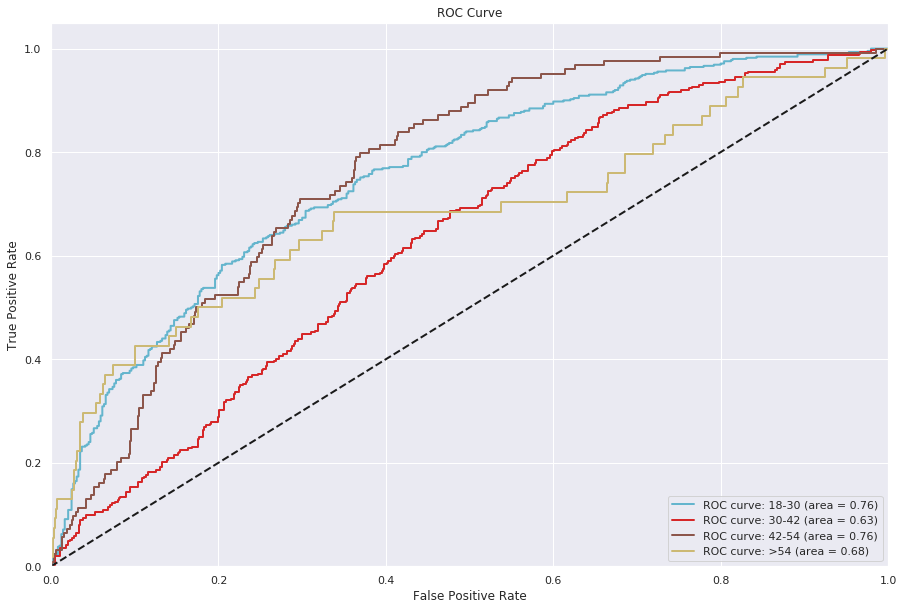

In [12]:
import matplotlib.colors as mcolors
import random

n_classes = len(age_labels)

y_pred_keras = model.predict(testImages)

# Plot linewidth.
lw = 2

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(testLabels[:, i], y_pred_keras[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)

for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

# Plot all ROC curves
plt.figure(figsize=(15,10))


base_colors = list(mcolors.BASE_COLORS.keys())
tab_colors = list(mcolors.TABLEAU_COLORS.keys())            
color_list = base_colors + tab_colors                                
random.shuffle(color_list)

colors = cycle(color_list)
labels = age_labels

for i, color, l in zip(range(n_classes), colors, labels):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve: {0} (area = {1:0.2f})'
             ''.format(l, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()